data: from https://zenodo.org/record/4060432#.X5ySHHhKgWo


Thesis: identify humans (voice), animals, instruments, water, door, car, explosion (boom, thunder)

3 Main CNN Models:

Spectrograms
MFCC Image Analysis
Mean-MFCC Coefficient Analysis

mfccs_processed = np.mean(mfcc.T, axis=0)
print(mfccs_processed)

To do items:

Update:
1. model on image analysis of Mel Frequency Spectrogram (images)
2. model on analysis of coefficients of MFCC (unless it ends up making sense to analyze the image as well)


- create new columns of labels I will use (tags too long and many)

- extract MFCC of all files to add to dataframe

- consider need to trim audio files to make same length, OR adding length to short files (padding them?)

In [2]:
import pandas as pd
import numpy as np
import time
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from PIL import Image
import skimage
import skimage.io
import os
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/sit

In [3]:
dev_info = pd.read_json('data/FSD50K.metadata/dev_clips_info_FSD50K.json').T
#dev_info = dev_info.T

In [10]:
#eval_info = pd.read_json('data/FSD50K.metadata/eval_clips_info_FSD50K.json').T


In [6]:
dev_info = dev_info.sort_index()
dev_info['track_num'] = dev_info.index
dev_info['track_num'] = dev_info['track_num'].apply(lambda x: str(x) + '.wav')
dev_info.head()

,title,description,tags,license,uploader,track_num
63,RalfHutterWorking.wav,"Ralf Hutter from Kraftwerk saying ""Working on ...","[male, voice]",http://creativecommons.org/licenses/by/3.0/,fectoper,63.wav
136,keyboard-rhymtic.wav,Noise of an average logitech keyboard. Pretty ...,"[keyboard, rhythmic, tap, type]",http://creativecommons.org/licenses/by/3.0/,Anton,136.wav
137,keyboard-typing.wav,Noise of an average logitech keyboard. Pretty ...,"[computer, environmental-sounds-research, key,...",http://creativecommons.org/licenses/by/3.0/,Anton,137.wav
221,bell.wav,simple *ting* sound,[bell],http://creativecommons.org/publicdomain/zero/1.0/,Erratic,221.wav
236,BUSSES.aiff,Departing busses\r\n at Utrecht Central Railwa...,"[bus, depart, drive, station]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,236.wav


## Data Wrangling

## padding audio (pad/trim to 5 seconds)

In [20]:
audio_dir = '/Users/Mateo/Springboard/FSD50k/data/FSD50K.dev_audio/'
list_of_file_names = dev_info.track_num.to_list()

/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


110250


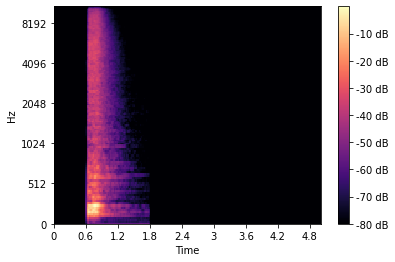

In [13]:
# load audio data
file_path = audio_dir + list_of_file_names[25]
data, sr = librosa.load(file_path)

#padding with random offset for shorter tracks

input_length = 5 * 22050 # 5 seconds * 22050 samples per second (the sample_rate)

if len(data) > input_length:
    data = data[:input_length]

elif input_length > len(data):
    max_offset = input_length - len(data)
    offset = np.random.randint(max_offset)
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")


# Fast Fourier Transform, a window for the results image
n_fft = 2048
# hop length slides the window (4:1 something er other?)
hop_length = 512
# converts audio spectrum into 128 evenly spaced groups based on human hearing
n_mels = 128

S = librosa.feature.melspectrogram(data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

print(len(data))

## Converting Spectrograms and saving as Image Files

In [14]:
#function for scaling spectrogram images (however, the datagenerator can do that too, so maybe unnecessary here)

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [19]:
# SPECtorgraMs

# changing into directory to save spectrogram images
path = '/Users/Mateo/Springboard/FSD50k/data/spec_100'
os.chdir(path)

start = time.time()

for i in range(100):
    file_path = audio_dir + list_of_file_names[i]
    data, sr = librosa.load(file_path)
    
    #padding/trimming to 5 seconds
    #padding with random offset for shorter tracks

    input_length = 5 * 22050 # 5 seconds * 22050 samples per second (the sample_rate)

    if len(data) > input_length:
        data = data[:input_length]

    elif input_length > len(data):
        max_offset = input_length - len(data)
        offset = np.random.randint(max_offset)
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
    
    
    
    # Fast Fourier Transform, a window for the results image
    n_fft = 2048
    # hop length slides the window (4:1 something er other?)
    hop_length = 512
    # converts audio spectrum into 128 evenly spaced groups based on human hearing
    n_mels = 128

    S = librosa.feature.melspectrogram(data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    #librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length)

    # # min-max scale to fit inside 8-bit range

    img = scale_minmax(S_DB, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    skimage.io.imsave(list_of_file_names[i][:-4] + '.png', img)    
    # to display impage # librosa.display.specshow(img, sr=sr, hop_length=hop_length)
    
end = time.time()
print(end - start)

25.194583892822266


### Extracting MFCC Features
#### (probably these will have to be separate dataframes with the full 50k records)


In [21]:
audio_dir = '/Users/Mateo/Springboard/FSD50k/data/FSD50K.dev_audio/'
list_of_file_names = dev_info.track_num.to_list()

In [22]:
#making a MFCC list (to add later to df)

mfcc_list = []

start = time.time()

for i in range(1,101):
    file_path = audio_dir + list_of_file_names[i]
    data, sr = librosa.load(file_path)
    
    #padding/trimming to 5 seconds with random offset for shorter tracks

    input_length = 5 * 22050

    if len(data) > input_length:
        data = data[:input_length]

    elif input_length > len(data):
        max_offset = input_length - len(data)
        offset = np.random.randint(max_offset)
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
    
    # extracting mfcc features
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    # mfccsscaled = np.mean(mfccs.T,axis=0)   # mean scaled MFCC, maybe use? consider other summary stats?
    mfcc_list.append(mfcc)
    
end = time.time()
print(end - start)

23.503243684768677


In [23]:
print(len(mfcc_list[0]), len(mfcc_list[0][0]))

13 216


In [24]:
len(mfcc_list)

100

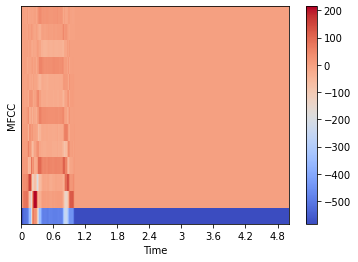

In [25]:
# Display MFCC
librosa.display.specshow(mfcc_list[75], x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [26]:
# saving mfcc's as a pickle

with open('/Users/Mateo/Springboard/FSD50k/data/mfcc_100.pkl', 'wb') as f:
    pickle.dump(mfcc_list, f)

In [28]:
# loading pickle

with open('/Users/Mateo/Springboard/FSD50k/data/mfcc_100.pkl', 'rb') as f:
    loaded_mfcc_list = pickle.load(f)

In [30]:
print("mfcc features:", len(loaded_mfcc_list[0]), ', number of time intervals:',len(loaded_mfcc_list[0][0]))

mfcc features: 13 , number of time intervals: 216


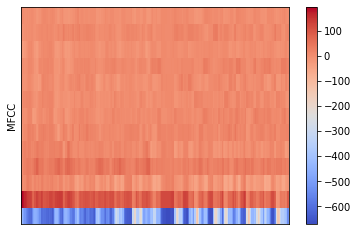

In [31]:
# Display MFCC
librosa.display.specshow(loaded_mfcc_list[0])
plt.ylabel('MFCC')
plt.colorbar()

## Making a stand in for the labels (placeholder labels)

In [33]:
dev_100_df = dev_info.iloc[:100].copy()

In [37]:
dev_100_df.head(50)

,title,description,tags,license,uploader,track_num,mf_labels
63,RalfHutterWorking.wav,"Ralf Hutter from Kraftwerk saying ""Working on ...","[male, voice]",http://creativecommons.org/licenses/by/3.0/,fectoper,63.wav,1
136,keyboard-rhymtic.wav,Noise of an average logitech keyboard. Pretty ...,"[keyboard, rhythmic, tap, type]",http://creativecommons.org/licenses/by/3.0/,Anton,136.wav,0
137,keyboard-typing.wav,Noise of an average logitech keyboard. Pretty ...,"[computer, environmental-sounds-research, key,...",http://creativecommons.org/licenses/by/3.0/,Anton,137.wav,0
221,bell.wav,simple *ting* sound,[bell],http://creativecommons.org/publicdomain/zero/1.0/,Erratic,221.wav,0
236,BUSSES.aiff,Departing busses\r\n at Utrecht Central Railwa...,"[bus, depart, drive, station]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,236.wav,0
237,CAR.aiff,Car departing / passing by,"[car, engine, passing]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,237.wav,0
247,allehoekenN.aiff,Dutch text fragment (translated as: all cornde...,"[dutch, male, speech]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,247.wav,1
263,childcries.aiff,child crying in a subway,"[children, crying]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,263.wav,0
281,treinREM.aiff,train passing by and the sound of brakes,"[environmental-sounds-research, field-recordin...",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,281.wav,0
283,treinlangs.aiff,train passing by,"[crescendo, environmental-sounds-research, train]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,283.wav,0


In [38]:
dev_100_df['mf_labels'] = dev_100_df['tags'].apply(lambda x: 1 if 'percussion' in x else 0)

In [39]:
dev_100_df['mf_labels'].value_counts()

0    87
1    13
Name: mf_labels, dtype: int64

In [52]:
#placeholder for target (y_train)
target_labels = dev_100_df['mf_labels']

### Build out keras architecture

In [48]:
# why did I not originally load this into an array?
mfcc_arr = np.array(mfcc_list)
mfcc_arr.shape

(100, 13, 216)

In [49]:
# Feature dimensions (MFCC x Time)
feature_dim_1 = mfcc_arr.shape[1] #MFCC features
# Second dimension of the feature is dim2
feature_dim_2 = mfcc_arr.shape[2] # Time
num_tracks =mfcc_arr.shape[0] # number of audio files
num_channels = 1
epochs = 20
batch_size = 100
verbose = 1
num_classes = 2 # len(target_labels)

# Reshaping to perform 2D convolution
# # Reshape to fit the network input (tracks, mfcc, time, channel last)
X_train = mfcc_arr.reshape(num_tracks, feature_dim_1, feature_dim_2, num_channels)

In [50]:
X_train.shape

(100, 13, 216, 1)

In [53]:
y_hot = to_categorical(target_labels) # keras function

In [54]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, num_channels)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [55]:
# alternate ADAM code

# adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
# model.compile(
#     loss='categorical_crossentropy', 
#     metrics=['accuracy'], 
#     optimizer=adam)

# # Display model architecture summary 
# model.summary()



model = get_model()

optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 215, 32)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 214, 48)       6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 213, 120)      23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 106, 120)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 106, 120)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 63600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)             

In [56]:
model.fit(X_train, y_hot, batch_size=batch_size, epochs=epochs, verbose=verbose)


Epoch 1/20
100/100 [==============================] - 2s 16ms/step - loss: 9.5714 - accuracy: 0.2200
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 67.2814 - accuracy: 0.8700
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 127.5738 - accuracy: 0.1300
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 12.7877 - accuracy: 0.8700
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 3.9756 - accuracy: 0.6500
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 2.7451 - accuracy: 0.8600
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 2.7802 - accuracy: 0.8300
Epoch 8/20
100/100 [==============================] - 1s 9ms/step - loss: 9.6038 - accuracy: 0.8700
Epoch 9/20
100/100 [==============================] - 1s 8ms/step - loss: 1.4398 - accuracy: 0.8100
Epoch 10/20
100/100 [==============================] - 1s 11ms/step - loss: 2.5643 - accuracy:

In [64]:
### Note, got 87%, but thats cuz it predicted it was not 
### a percussion instrument 100%, with 87 non-percussion events



# Evaluating the model on the training and testing set

score = model.evaluate(X_train, y_hot, verbose=1)
accuracy = 100*score[1]
print("Training accuracy: %.2f%%" % accuracy) 

# score = model.evaluate(x_test, y_test, verbose=0)
# print("Testing Accuracy: ", score[1])

100/100 [==============================] - 0s 3ms/step
Training accuracy: 87.00%


# CNN from Spectogram

In [65]:
dev_100_df['num'] = dev_100_df.index

In [66]:
dev_100_df['png_name'] = dev_100_df['num'].apply(lambda x: str(x) + '.png')

In [67]:
dev_100_df['mf_labels'] = dev_100_df['mf_labels'].apply(lambda x: str(x))

In [68]:
dev_100_df.head()

,title,description,tags,license,uploader,track_num,mf_labels,num,png_name
63,RalfHutterWorking.wav,"Ralf Hutter from Kraftwerk saying ""Working on ...","[male, voice]",http://creativecommons.org/licenses/by/3.0/,fectoper,63.wav,0,63,63.png
136,keyboard-rhymtic.wav,Noise of an average logitech keyboard. Pretty ...,"[keyboard, rhythmic, tap, type]",http://creativecommons.org/licenses/by/3.0/,Anton,136.wav,0,136,136.png
137,keyboard-typing.wav,Noise of an average logitech keyboard. Pretty ...,"[computer, environmental-sounds-research, key,...",http://creativecommons.org/licenses/by/3.0/,Anton,137.wav,0,137,137.png
221,bell.wav,simple *ting* sound,[bell],http://creativecommons.org/publicdomain/zero/1.0/,Erratic,221.wav,0,221,221.png
236,BUSSES.aiff,Departing busses\r\n at Utrecht Central Railwa...,"[bus, depart, drive, station]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,236.wav,0,236,236.png


In [71]:
from keras.preprocessing.image import ImageDataGenerator


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)


train_generator=datagen.flow_from_dataframe(
    dataframe=dev_100_df,
    directory='/Users/Mateo/Springboard/FSD50k/data/spec_100',
    x_col='png_name',
    y_col="mf_labels",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 75 validated image filenames belonging to 2 classes.


In [72]:
#Dis worked... (need to adjust for classes, maybe recategorize files into folders, but shouldn't really matter...)

num_classes=2

# model=keras.Sequential(
#         [
#             keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
#             keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
#             keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
#             keras.layers.Flatten(),
#             keras.layers.Dense(1)
#         ])
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Define Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#Compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [73]:
#Train and Test The Model
model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10
3/3 [==============================] - 1s 489ms/step - loss: 0.5335 - accuracy: 0.9467
Epoch 2/10
3/3 [==============================] - 1s 304ms/step - loss: 1.1930 - accuracy: 0.9600
Epoch 3/10
3/3 [==============================] - 1s 306ms/step - loss: 0.3026 - accuracy: 0.9600
Epoch 4/10
3/3 [==============================] - 1s 306ms/step - loss: 0.3125 - accuracy: 0.9467
Epoch 5/10
3/3 [==============================] - 1s 313ms/step - loss: 0.1638 - accuracy: 0.9733
Epoch 6/10
3/3 [==============================] - 1s 311ms/step - loss: 0.1585 - accuracy: 0.9600
Epoch 7/10
3/3 [==============================] - 1s 333ms/step - loss: 0.1074 - accuracy: 0.9600
Epoch 8/10
3/3 [==============================] - 1s 326ms/step - loss: 0.0677 - accuracy: 0.9600
Epoch 9/10
3/3 [==============================] - 1s 350ms/step - loss: 0.0452 - accuracy: 0.9867
Epoch 10/10
3/3 [==============================] - 1s 335ms/step - loss: 0.0388 - accuracy: 0.9733


In [ ]:
dev_100_df.mf_labels

In [74]:
preds = model.predict(train_generator)

array([[1.0000000e+00, 2.1068916e-09],
       [9.9979788e-01, 2.0209918e-04],
       [9.9999940e-01, 6.2911590e-07],
       [9.9994695e-01, 5.3101812e-05],
       [9.9999774e-01, 2.2681670e-06],
       [6.7346060e-01, 3.2653937e-01],
       [1.0000000e+00, 3.9773631e-15],
       [9.9999714e-01, 2.8963784e-06],
       [9.9913764e-01, 8.6237438e-04],
       [9.9999619e-01, 3.8318708e-06],
       [9.9998391e-01, 1.6076905e-05],
       [9.9996614e-01, 3.3851600e-05],
       [9.9999857e-01, 1.3733545e-06],
       [1.0000000e+00, 1.9235824e-09],
       [9.9999976e-01, 2.8540620e-07],
       [9.9995446e-01, 4.5496159e-05],
       [1.0000000e+00, 2.5690824e-10],
       [9.9983120e-01, 1.6877566e-04],
       [9.9804270e-01, 1.9572161e-03],
       [1.0000000e+00, 1.8150039e-09],
       [9.9999821e-01, 1.7566268e-06],
       [1.0000000e+00, 1.2538597e-08],
       [9.9995399e-01, 4.6020275e-05],
       [1.0000000e+00, 1.2025470e-09],
       [9.9893779e-01, 1.0622694e-03],
       [9.9985909e-01, 1.

In [75]:
# Evaluating the model on the training and testing set

score = model.evaluate(train_generator)
accuracy = 100*score[1]
print("Training accuracy: %.2f%%" % accuracy) 

3/3 [==============================] - 0s 111ms/step
Training accuracy: 97.33%


## Alternate ways to load images into dataset without ImageGenerator
### issues here with having images in correct numpy array shape...

In [ ]:
 # Worked !!! Have to put files in categorical folders though....

# from keras.preprocessing.image import ImageDataGenerator

# # create a data generator
# datagen = ImageDataGenerator()

# spec_dir ='/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/'

# # load and iterate training dataset
# train_it = datagen.flow_from_directory(
#     spec_dir,
#     target_size=(216, 128),
#     batch_size=32,
#     class_mode='binary')

# # load and iterate validation/test dataseta
# val_it = datagen.flow_from_directory('data/validation/', class_mode='binary', batch_size=64)
# test_it = datagen.flow_from_directory('data/test/', class_mode='binary', batch_size=64)

In [ ]:
# #Train and Test The Model
# model.fit(train_it, epochs=10, verbose=1)


# optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
# # optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=optimizer,
#               metrics=['accuracy'])
# model.fit(train_it, epochs=epochs, verbose=verbose) #batch_size=batch_size, removed # y_hot, # no y input with generator

In [ ]:
# # This works but switch to datagenerator at some point (array type messing me up!)

# IMG_WIDTH=216
# IMG_HEIGHT=128

# def create_dataset_PIL(img_folder):
    
#     img_data_array=[]
#     # class_name=[]
#     for file in os.listdir(img_folder):
#         # for file in os.listdir(os.path.join(img_folder, dir1)): # not necessary for file folder structure
#        if '.png' in file:
#             image_path= os.path.join(img_folder, file)
#             image= np.array(Image.open(image_path))
#             image= np.resize(image,(IMG_HEIGHT,IMG_WIDTH,3))
#             image = image.astype('float32')
#             image /= 255  
#             img_data_array.append(image)
#             # class_name.append(dir1)
#     return img_data_array #, class_name

# img_folder = '/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/'

# PIL_img_data =create_dataset_PIL(img_folder) ####, class_name

# X_train_spec[0].shape
# X_train_spec = PIL_img_data
## history = model.fit(np.array(PIL_img_data, np.float32), y_hot, epochs=5)

In [ ]:
# #Another way to load images

# images = []
# for f in glob.iglob("/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/class_1/*.png"):
#     images.append(np.asarray(Image.open(f)))

# for f in glob.iglob("/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/class_2/*.png"):
#     images.append(np.asarray(Image.open(f)))    
# images = np.array(images)

## End | Notes Below

In [ ]:
# Kates function for extracting MFCC 

import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import soundfile
import sklearn
import shutil
import pandas as pd
from numpy import argmax
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import json

#to get mfcc features for a single file
def extract_mfcc_features(file_path):
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

#get mfcc features for all files
def get_all_features(df, audio_folder):
    features = []
    for item in df.index:
        filename = item + '.wav'
        data = extract_mfcc_features(f'{audio_folder}/{filename}')
        class_label = df.loc[item]['instrument_family_str']
        features.append([data, class_label, item])

In [ ]:
##### Heres a function for padding silence into the audio file

I did a small script which allows you to prepend your signal with a silence in order to obtain the target duration in seconds. It uses the scipy function for reading of the wav file.

#!/usr/bin/env python

from __future__ import print_function, division
import scipy.io.wavfile as wavf
import numpy as np
from sys import argv

def pad_audio(data, fs, T):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

if __name__ == "__main__":
    if len(argv) != 4:
        print("Wrong arguments.")
        print("Use: %s in.wav out.wav target_time_s" % argv[0])
    else:
        in_wav = argv[1]
        out_wav = argv[2]
        T = float(argv[3])        
        # Read the wav file
        fs, in_data = wavf.read(in_wav)
        # Prepend with zeros
        out_data = pad_audio(in_data, fs, T)
        # Save the output file
        wavf.write(out_wav, fs, out_data)

In [ ]:
# This trims silence????

# trim silent edges

whale_song, _ = librosa.effects.trim(y)

In [ ]:
# helpful articles

https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
https://pytorch.org/audio/stable/index.html
(good explanations of Mel and CNN) https://scottmduda.medium.com/urban-environmental-audio-classification-using-mel-spectrograms-706ee6f8dcc1
    
(indepth explanation of MFS MFCC)    https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
 free course on audio processing   https://www.coursera.org/learn/audio-signal-processing
    
Urban sound dataset (Consideration, 4seconds in length) https://urbansounddataset.weebly.com/urbansound8k.html
    
    
    
# audio walk through with keras
http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/

In [ ]:
# Note paramets for loading this file, "res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5", 
# don't know if they are significant or not..., I think it clips the track, unsure what kaier_fast does...)
# is it better for some reason, there is a difference with it...

X, sample_rate = librosa.load(file_path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# MFCC
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
default sample_rate = 22050

In [ ]:
#duration param to trim the length of file?

melspec_params = {
    'n_mels': 128,
    'duration': 4*22050,
    'hop_length': 512,
    'n_fft': 2048,
    'fmin': 20
}

## Padding function

def load_audio(params, file_path):
    y, sr = librosa.load(parent_directory + sub_dir + '/' + file_list[i])

    # clip silence
    yt, index = librosa.effects.trim(y, top_db=60)       

    # pad to a length of 4s
    if len(yt) > params['duration']:
        yt = yt[:params['duration']]
    else:
        padding = params['duration'] - len(yt)
        offset = padding // 2
        yt = np.pad(yt, (offset, params['duration'] - len(yt) - offset), 'constant')
    
    return yt, sr


# FUNCTION FOR SAVING IMAGE


### Process WAV Files

for sub_dir in sub_dirs:
    file_list = os.listdir(parent_directory + sub_dir)
    file_list = [x for x in file_list if 'wav' in x]
    file_labels = [int(x.split('-')[1]) for x in file_list]
    print('processing {}'.format(sub_dir))
    
    for i in range(0, len(file_list)):
        y, sr = load_audio(melspec_params, parent_directory + sub_dir + '/' + file_list[i])
        melspec = create_melspec(melspec_params, y, sr)
        melspec_color = mono_to_color(melspec)
        
        # HERE IS THE SAVING PART
        np.savez(numpy_save_directory + sub_dir + '/' + file_list[i][:-4], melspec_color)

In [ ]:
# example cnnn

#NOTE loads images into a list!
# ### Train Model

oof_labels = []
oof_preds = []

for sub_dir in sub_dirs:
    X_train = []
    train_labels = []
    X_valid = [] 
    valid_labels = [] 
    
    for fold in sub_dirs:
        file_list = os.listdir(numpy_save_directory + fold)
        if fold == sub_dir:
            for file_name in file_list:
                with np.load(numpy_save_directory + fold + '/' + file_name) as f:
                    X_valid.append(f['arr_0'])
                valid_labels.append(int(file_name.split('-')[1]))
                y_valid = np.zeros((len(valid_labels), 10)).astype(int)
                for i, j in enumerate(valid_labels):
                    y_valid[i, j] = 1
        else:
            for file_name in file_list:
                with np.load(numpy_save_directory + fold + '/' + file_name) as f:
                    X_train.append(f['arr_0'])
                train_labels.append(int(file_name.split('-')[1]))
                y_train = np.zeros((len(train_labels), 10)).astype(int)
                for i, j in enumerate(train_labels):
                    y_train[i, j] = 1

    train_dataset = TrainDataset(X_train, train_labels, transforms_dict['train'])
    valid_dataset = TrainDataset(X_valid, valid_labels, transforms_dict['train'])

    train_loader = DataLoader(train_dataset, batch_size=model_params['batch_size'], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=model_params['batch_size'], shuffle=False)
 ###

etc...    

In [ ]:
# loading data with preprocessing

def preprocess_audio_mel_T(audio, sample_rate=16000, window_size=20, #log_specgram
                 step_size=10, eps=1e-10):

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40)/40

    return mel_db.T


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = preprocess_audio_mel_T(data)
    return data

In [ ]:
# dis is what glob does
train_files = glob.glob("../input/audio_train/*.wav")
test_files = glob.glob("../input/audio_test/*.wav")
train_labels = pd.read_csv("../input/train.csv")

In [ ]:
#pad/trim

#padding with random offset (why?, I guess standardizes where in the track the silence is...)
input_length = 5 * 22050 # 5 seconds # 22050 samples per second (the sample_rate)

if len(data)>input_length:

#     this puts slices the audio track at a random place, WILL not use this, instead trim end of track...
#     max_offset = len(data)-input_length
#     offset = np.random.randint(max_offset)
#     data = data[offset:(input_length+offset)]
    data = data[:input_length]

elif input_length > len(data):
    max_offset = input_length - len(data)
    offset = np.random.randint(max_offset)
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")


In [ ]:
  # labeling pickle files instructions:
    
    # store extracted training data
    training_examples.to_pickle('Extracted_Features\\' + training_name + '_features.pkl')
    training_labels.to_pickle('Extracted_Features\\' + training_name + '_labels.pkl')

    # store extracted validation data
    validation_examples.to_pickle('Extracted_Features\\' + validation_name + '_features.pkl')
    validation_labels.to_pickle('Extracted_Features\\' + validation_name + '_labels.pkl')

In [ ]:
# import glob
# import imageio

# for image_path in glob.glob("/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/*.png"):
#     im = imageio.imread(image_path)
#     plt.imshow(im)